Total rows: 10050
Mean Label: 0.9423835124378109
Median Label: 1.0
JUNK rate: 5.4%
High-Label (>=0.85): 8633 (85.9%)
Medium-Label (0.5–0.85): 1130 (11.2%)
Low-Label (<0.5): 287 (2.9%)
Ambiguous (multi-code): 4401 (43.8%)

Label distribution:
Label_bin
(0.0, 0.25]     0.090543
(0.25, 0.5]     2.806841
(0.5, 0.75]     5.694165
(0.75, 1.0]    91.408451
Name: proportion, dtype: float64


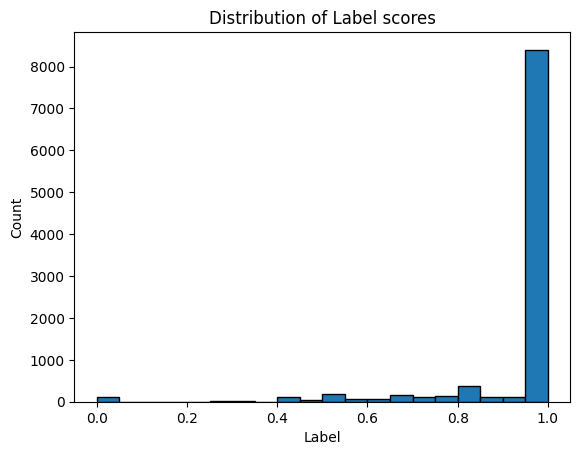

In [12]:
import pandas as pd

# Load output
df = pd.read_csv("output.csv")

# Convert Label to float
df["Label"] = df["Label"].astype(float)

# --- Summary stats ---
print("Total rows:", len(df))
print("Mean Label:", df["Label"].mean())
print("Median Label:", df["Label"].median())

# JUNK rate
junk_rate = (df["nucc_codes"] == "JUNK").mean()
print(f"JUNK rate: {junk_rate*100:.1f}%")

# High vs low Label counts
high = (df["Label"] >= 0.85).sum()
mid  = ((df["Label"] >= 0.5) & (df["Label"] < 0.85)).sum()
low  = (df["Label"] < 0.5).sum()

print(f"High-Label (>=0.85): {high} ({high/len(df)*100:.1f}%)")
print(f"Medium-Label (0.5–0.85): {mid} ({mid/len(df)*100:.1f}%)")
print(f"Low-Label (<0.5): {low} ({low/len(df)*100:.1f}%)")

# Ambiguous mappings (multiple codes)
ambig = df["nucc_codes"].str.contains("\|").sum()
print(f"Ambiguous (multi-code): {ambig} ({ambig/len(df)*100:.1f}%)")

# --- Distribution overview ---
df["Label_bin"] = pd.cut(df["Label"], bins=[0,0.25,0.5,0.75,1.0])
print("\nLabel distribution:")
print(df["Label_bin"].value_counts(normalize=True).sort_index() * 100)

# --- Optional: plot histogram (if using Jupyter) ---
import matplotlib.pyplot as plt
plt.hist(df["Label"], bins=20, edgecolor="black")
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of Label scores")
plt.show()


In [13]:
# Low-Label or JUNK rows
low_conf_df = df[(df["Label"] < 0.5) | (df["nucc_codes"] == "JUNK")]
low_conf_df.to_csv("problem_cases.csv", index=False)
print(f"Saved {len(low_conf_df)} low-Label / junk rows to problem_cases.csv")

# Medium-Label (borderline) rows
mid_conf_df = df[(df["Label"] >= 0.5) & (df["Label"] < 0.85)]
mid_conf_df.to_csv("borderline_cases.csv", index=False)

Saved 541 low-Label / junk rows to problem_cases.csv


In [14]:
# Low-Label or JUNK rows
junk_df = df[(df["nucc_codes"] == "JUNK")]
junk_df.to_csv("junk_cases.csv", index=False)
print(f"Saved {len(junk_df)} junk rows to junk_cases.csv")

Saved 541 junk rows to junk_cases.csv


In [7]:
import pandas as pd
import json
import argparse
import re
import numpy as np
from collections import Counter
from typing import List, Dict, Tuple, Set
from rapidfuzz import fuzz, process
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer

# List all the installed libraries with their versions
import pkg_resources
installed_packages = {pkg.key: pkg.version for pkg in pkg_resources.working_set}

# Libraries you're using
libraries = [
    "pandas", "numpy", "rapidfuzz", "tqdm", "sentence_transformers", "argparse", "re", "json", "collections"
]

# Get versions for the libraries you're using
versions = {lib: installed_packages.get(lib.lower(), "not installed") for lib in libraries}

for lib, version in versions.items():
    print(f"{lib}: {version}")


pandas: 1.5.3
numpy: 1.26.4
rapidfuzz: 3.14.2
tqdm: 4.66.1
sentence_transformers: not installed
argparse: not installed
re: not installed
json: not installed
collections: not installed


In [8]:
import platform
import sys

# Get the Python version and platform details
python_version = sys.version
python_platform = platform.system()
python_platform_version = platform.version()
python_architecture = platform.architecture()

# Print all relevant Python build details
print(f"Python Version: {python_version}")
print(f"Platform: {python_platform}")
print(f"Platform Version: {python_platform_version}")
print(f"Architecture: {python_architecture}")


Python Version: 3.11.3 (v3.11.3:f3909b8bc8, Apr  4 2023, 20:12:10) [Clang 13.0.0 (clang-1300.0.29.30)]
Platform: Darwin
Platform Version: Darwin Kernel Version 25.0.0: Wed Sep 17 21:41:39 PDT 2025; root:xnu-12377.1.9~141/RELEASE_ARM64_T8103
Architecture: ('64bit', '')
